<h1> <center> <font color='green'> Telecom Churn Prediction</font></center></h1>

<p>In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate.
Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

For many incumbent operators, retaining high profitable customers is the number one business
goal. To reduce customer churn, telecom companies need to predict which customers are at high risk of churn. In this project, you will analyze customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn.

In this competition, your goal is to build a machine learning model that is able to predict churning customers based on the features provided for their usage. </p>

<h4> <center> Objective </center></h4>
The main goal of the case study is to build ML models to predict churn. The predictive model that you’re going to build will the following purposes:

1. It will be used to predict whether a high-value customer will churn or not, in near future (i.e. churn phase). By knowing this, the company can take action steps such as providing special plans, discounts on recharge etc.
2. It will be used to identify important variables that are strong predictors of churn. These variables may also indicate why customers choose to switch to other networks.
3. Even though overall accuracy will be your primary evaluation metric, you should also mention other metrics like precision, recall, etc. for the different models that can be used for evaluation purposes based on different business objectives. For example, in this problem statement, one business goal can be to build an ML model that identifies customers who'll definitely churn with more accuracy as compared to the ones who'll not churn.
 4. Recommend strategies to manage customer churn based on your observations.


<h4> <center> Important Terminology </center></h4>

| Acronyms    | Description                                                                         |
|-------------|-------------------------------------------------------------------------------------|
| CIRCLE_ID   | Telecom circle area to which the customer belongs to                                |
| LOC         | Local calls  within same telecom   circle                                           |
| STD         | STD calls  outside the calling   circle                                             |
| IC          | Incoming calls                                                                      |
| OG          | Outgoing calls                                                                      |
| T2T         | Operator T to T ie within same operator mobile to mobile                            |
| T2M         | Operator T to other operator mobile                                                 |
| T2O         | Operator T to other operator fixed line                                             |
| T2F         | Operator T to fixed lines of T                                                      |
| T2C         | Operator T to its own call center                                                   |
| ARPU        | Average revenue per user                                                            |
| MOU         | Minutes of usage  voice calls                                                       |
| AON         | Age on network  number of days the   customer is using the operator T network       |
| ONNET       | All kind of calls within the same operator network                                  |
| OFFNET      | All kind of calls outside the operator T network                                    |
| ROAM        | Indicates that customer is in roaming zone during the call                          |
| SPL         | Special calls                                                                       |
| ISD         | ISD calls                                                                           |
| RECH        | Recharge                                                                            |
| NUM         | Number                                                                              |
| AMT         | Amount in local currency                                                            |
| MAX         | Maximum                                                                             |
| DATA        | Mobile internet                                                                     |
| 3G          | 3G network                                                                           |
| AV          | Average                                                                             |
| VOL         | Mobile internet usage volume in MB                                                  |
| 2G          | 2G network                                                                           |
| PCK         | Prepaid service schemes called PACKS                                             |
| NIGHT       | Scheme to use during specific night hours only                                      |
| MONTHLY     | Service schemes with validity equivalent to a month                                 |
| SACHET      | Service schemes with validity smaller than a month                                  |
| *.6         | KPI for the month of June                                                           |
| *.7         | KPI for the month of July                                                           |
| *.8         | KPI for the month of August                                                         |
| FB_USER     | Service scheme to avail services of Facebook and similar social   networking sites  |
| VBC         | Volume based cost  when no specific   scheme is not purchased and paid as per usage |

Import the necessary libraries.

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix
from xgboost import XGBClassifier
from warnings import filterwarnings

pd.set_option("display.max_rows", 300)
pd.set_option("display.max_columns", 300)
filterwarnings('ignore')

In [53]:
plt.rcParams["figure.autolayout"] = True

In [54]:
## Global Variables
seed = 42
hvc_threshold = 70.0 # High value Customers
miss_threshold = 40.0 # Threshold to remove the columns that have this % missing values.
corr_threshold = 0.7
pca_comp = 50 # PCA components
test_set_size = 0.2 # Size of test set when doing a train-test-split

<h4> Custom Functions </h4>
<font color='red'> Note: </font>
The following custom functions are created after iterative experimentations, so as to make the code much more modular.

In [55]:
def create_total_data_recharge_columns(temp):
    """
    New columns related to recharge values are created.
    """
    temp['total_data_rech_amt_6'] = temp['av_rech_amt_data_6'] * temp['total_rech_data_6']
    temp['total_data_rech_amt_7'] = temp['av_rech_amt_data_7'] * temp['total_rech_data_7']
    temp['total_data_rech_amt_8'] = temp['av_rech_amt_data_8'] * temp['total_rech_data_8']

    # Drop the columns already accounted for 
    drop_cols = ['total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8','av_rech_amt_data_6', 'av_rech_amt_data_7']
    temp = temp.drop(drop_cols, axis=1)

    temp['total_rech_amt_6'] = temp['total_rech_amt_6'].fillna(0)
    temp['total_rech_amt_7'] = temp['total_rech_amt_7'].fillna(0)
    temp['total_data_rech_amt_6'] = temp['total_data_rech_amt_6'].fillna(0)
    temp['total_data_rech_amt_7'] = temp['total_data_rech_amt_7'].fillna(0)
    return temp

def filter_hvc(temp):
    """
    This function is used to remove the High Value customers from the dataset.
    """    
    good_phase_average_rech_amt = (temp['total_rech_amt_6'].fillna(0) + temp['total_rech_amt_7'].fillna(0) + temp['total_data_rech_amt_6'].fillna(0) + temp['total_data_rech_amt_7'].fillna(0) ) / 2
    gd_phase_avg_rech_amt_70 = np.percentile(good_phase_average_rech_amt, hvc_threshold)
    
    temp  = temp[good_phase_average_rech_amt > gd_phase_avg_rech_amt_70]
    return temp

def missing_values(temp):
    """
    Drop the columns with more percentage of null values than the threshold.
    """
    miss_vals = round(temp.isna().sum() / len(temp) * 100, 2).sort_values(ascending=False)
    
    drop_miss_cols = miss_vals[miss_vals > miss_threshold].index.tolist()
    temp = temp.drop(drop_miss_cols,axis=1)
    
    return temp

def redundant_columns(temp):
    """
    This function is used to drop redundant columns 
    """
    ## Dropping date columns:
    date_cols = [col for col in list(temp.columns) if 'date' in col]
    temp.drop(date_cols,axis=1,inplace=True)

    ## Dropping Id and Circle_id columns as they are redundant for training the model:
    temp.drop(["id","circle_id"],axis=1,inplace=True)

    ## Checking columns with only one unique value. Since there is no variance, these columns do not add any  value to model.
    drop_singles = []

    for col in temp.columns:
        if temp[f'{col}'].nunique() == 1:
            drop_singles.append(col)
            
    temp = temp.drop(drop_singles,axis=1)
    return temp


def drop_correlated_features(temp):
    """
    The following columns were found out to be highly correlated thus removing these particular columns via hardcoding it.
    """
    drop_col_corr = ['loc_og_t2m_mou_6', 'std_og_t2t_mou_6', 'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2m_mou_6', 'std_og_t2m_mou_7', 
                    'std_og_t2m_mou_8', 'total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8', 'loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7', 
                    'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_6', 'loc_ic_t2m_mou_7', 'loc_ic_t2m_mou_8', 'std_ic_t2m_mou_6', 'std_ic_t2m_mou_7', 
                    'std_ic_t2m_mou_8', 'total_ic_mou_6', 'total_ic_mou_7', 'total_ic_mou_8', 'total_rech_amt_6', 'total_rech_amt_7', 
                    'total_rech_amt_8', 'vol_3g_mb_6', 'vol_3g_mb_7', 'vol_3g_mb_8', 'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8',
                    'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8', 'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8',
                    'loc_ic_t2f_mou_6', 'loc_ic_t2f_mou_7', 'loc_ic_t2f_mou_8']

    # Drop the high corr columns
    temp.drop(drop_col_corr, axis=1, inplace=True)
    temp.shape
    
    return temp

def create_mou(temp):
    temp['total_mou_6'] = temp['onnet_mou_6'] + temp['offnet_mou_6']
    temp['total_mou_7'] = temp['onnet_mou_7'] + temp['offnet_mou_7']
    temp['total_mou_8'] = temp['onnet_mou_8'] + temp['offnet_mou_8']

    # Drop the redundant columns
    temp.drop(['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8'], axis=1, inplace=True)
    
    return temp


def create_good_phase_cols(temp):
    col_for_6_7 = [col[:-2] for col in temp.columns if '6' in col or '7' in col]
    
    for col in set(col_for_6_7):
        temp[f'gd_ph_{col}'] = ( temp[f'{col}_6'] + temp[f'{col}_7'] ) / 2
        temp.drop([f'{col}_6', f'{col}_7'], axis=1, inplace=True)

    return temp 

def vbc_cols(temp):
    temp['gd_ph_vbc_3g'] = ( temp['jul_vbc_3g'] + temp['jun_vbc_3g'] ) / 2

    # Drop redundant column
    temp.drop(['jul_vbc_3g', 'jun_vbc_3g'], axis=1, inplace=True)

    # Rename the august column for vbc to vbc_3g_8
    temp['vbc_3g_8'] = temp['aug_vbc_3g']
    temp.drop('aug_vbc_3g', axis=1, inplace=True)
    
    return temp

def cap_outlier(temp):    
    """
    This function is used to cap the outliers from some of the columns in the dataset. 
    """
    ## Capping the outliers to certain values:
    col_upr_lmt = [('arpu_8', 7000), ('loc_og_mou_8', 4000), ('max_rech_amt_8', 1000 ), ('last_day_rch_amt_8', 1000 ), 
            ('aon', 3000), ('total_mou_8', 4000)]
    
    for col, value in col_upr_lmt:
        temp[col] = temp[col].apply(lambda x : x if x < value else value)

    return temp 

def impute_numeric(temp):    
    """
    This function is used to efficiently impute the missing values from numeric columns.
    """
    numeric_cols = temp.select_dtypes(["float64","int64"]).columns.tolist()
    imputer = SimpleImputer(missing_values= np.NaN, strategy='constant',fill_value=0)
    imputer = imputer.fit(temp[numeric_cols])
    temp[numeric_cols] =  imputer.fit_transform(temp[numeric_cols])
    return temp

In [56]:
master = pd.read_csv("./train.csv")
master.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,0,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,31.277,87.009,7.527,48.58,124.38,1.29,32.24,96.68,2.33,0.00,0.0,0.0,0.00,0.0,0.00,2.23,0.00,0.28,5.29,16.04,2.33,0.00,0.00,0.00,0.00,0.00,0.00,7.53,16.04,2.61,46.34,124.38,1.01,18.75,80.61,0.0,0.00,0.0,0.0,0.0,0.0,0.0,65.09,204.99,1.01,0.0,0.0,0.0,8.20,0.63,0.00,0.38,0.0,0.0,81.21,221.68,3.63,2.43,3.68,7.79,0.83,21.08,16.91,0.00,0.00,0.00,3.26,24.76,24.71,0.00,7.61,0.21,7.46,19.96,14.96,0.0,0.0,0.0,0.0,0.0,0.0,7.46,27.58,15.18,11.84,53.04,40.56,0.0,0.0,0.66,0.0,0.0,0.0,1.11,0.69,0.00,3,2,2,77,65,10,65,65,10,6/22/2014,7/10/2014,8/24/2014,65,65,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.00,0.00,0.0,0.00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,1958,0.0,0.0,0.0,0
1,1,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.000,122.787,42.953,0.00,0.00,0.00,0.00,25.99,30.89,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,22.01,29.79,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,30.73,31.66,0.00,0.0,0.0,0.00,30.73,31.66,1.68,19.09,10.53,1.41,18.68,11.09,0.35,1.66,3.40,3.44,39.44,25.03,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,3.44,39.44,25.04,0.0,0.0,0.01,0.0,0.0,0.0,0.00,0.00,0.00,3,4,5,0,145,50,0,145,50,6/12/2014,7/10/2014,8/26/2014,0,0,0,NaN,7/8/2014,NaN,NaN,1.0,NaN,NaN,145.0,NaN,NaN,0.0,NaN,NaN,1.0,NaN,Na

----

<h3><center>Exploratory Data Analysis</center> </h3>

In [57]:
eda = master.copy() ## Create a new object for performing eda.
eda.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,0,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,31.277,87.009,7.527,48.58,124.38,1.29,32.24,96.68,2.33,0.00,0.0,0.0,0.00,0.0,0.00,2.23,0.00,0.28,5.29,16.04,2.33,0.00,0.00,0.00,0.00,0.00,0.00,7.53,16.04,2.61,46.34,124.38,1.01,18.75,80.61,0.0,0.00,0.0,0.0,0.0,0.0,0.0,65.09,204.99,1.01,0.0,0.0,0.0,8.20,0.63,0.00,0.38,0.0,0.0,81.21,221.68,3.63,2.43,3.68,7.79,0.83,21.08,16.91,0.00,0.00,0.00,3.26,24.76,24.71,0.00,7.61,0.21,7.46,19.96,14.96,0.0,0.0,0.0,0.0,0.0,0.0,7.46,27.58,15.18,11.84,53.04,40.56,0.0,0.0,0.66,0.0,0.0,0.0,1.11,0.69,0.00,3,2,2,77,65,10,65,65,10,6/22/2014,7/10/2014,8/24/2014,65,65,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.00,0.00,0.0,0.00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,1958,0.0,0.0,0.0,0
1,1,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.000,122.787,42.953,0.00,0.00,0.00,0.00,25.99,30.89,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,22.01,29.79,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,30.73,31.66,0.00,0.0,0.0,0.00,30.73,31.66,1.68,19.09,10.53,1.41,18.68,11.09,0.35,1.66,3.40,3.44,39.44,25.03,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,3.44,39.44,25.04,0.0,0.0,0.01,0.0,0.0,0.0,0.00,0.00,0.00,3,4,5,0,145,50,0,145,50,6/12/2014,7/10/2014,8/26/2014,0,0,0,NaN,7/8/2014,NaN,NaN,1.0,NaN,NaN,145.0,NaN,NaN,0.0,NaN,NaN,1.0,NaN,Na

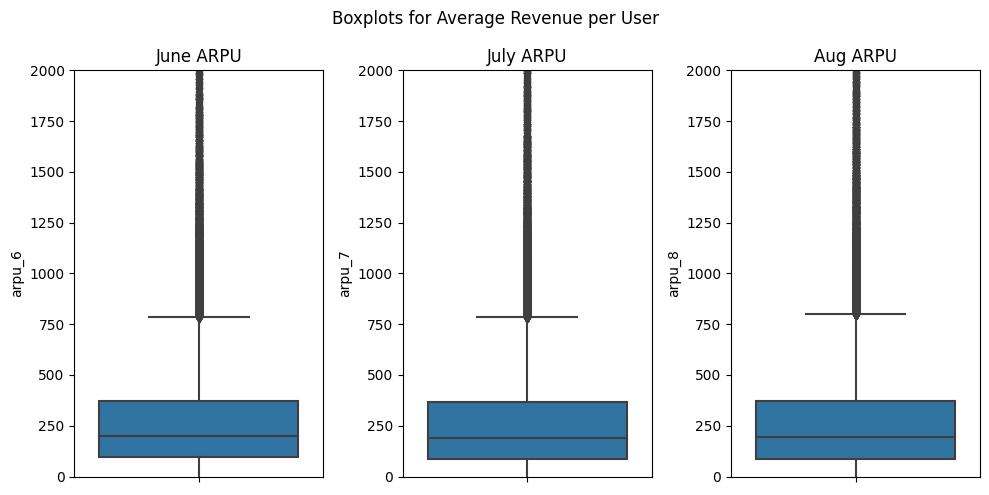

In [121]:
## Average Revenue per User (ARPU)
arpu = [col for col in list(eda.columns) if 'arpu' in col]
df = eda[arpu]

fig, ax = plt.subplots(1,3, figsize=(10,5))
plt.suptitle("Boxplots for Average Revenue per User");

sns.boxplot(df,y="arpu_6",ax=ax[0])
ax[0].set_title("June ARPU")
ax[0].set_ylim([0, 2000])

sns.boxplot(df,y="arpu_7",ax=ax[1])
ax[1].set_title("July ARPU")
ax[1].set_ylim([0, 2000])

sns.boxplot(df,y="arpu_8",ax=ax[2])
ax[2].set_title("Aug ARPU")
ax[2].set_ylim([0, 2000])

plt.show()

Observation: <br>
The average revenue per user is roughly the same for the three months.

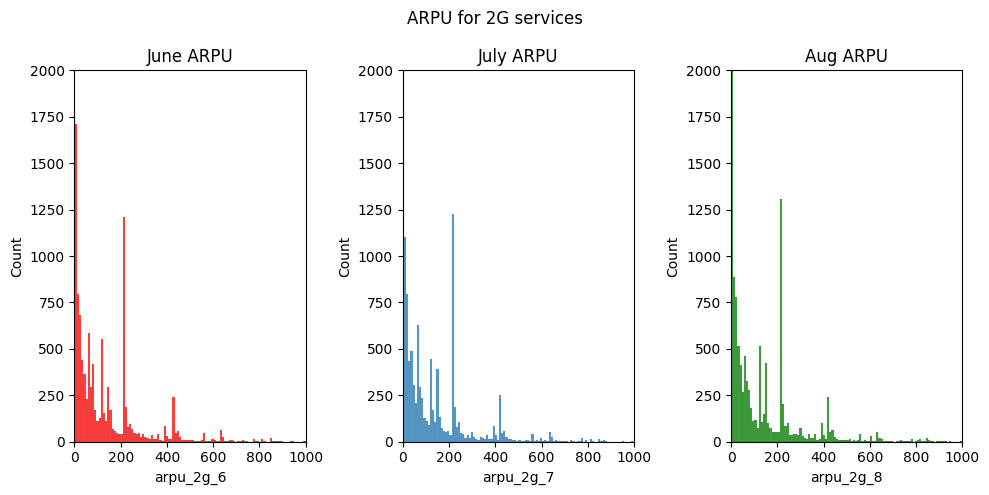

In [120]:
## Average Revenue per User (ARPU) 2G service
arpu = [col for col in list(eda.columns) if 'arpu' in col]
df = eda[arpu]

fig, ax = plt.subplots(1,3, figsize=(10,5))
plt.suptitle("ARPU for 2G services");

sns.histplot(df["arpu_2g_6"],ax=ax[0],color='r')
ax[0].set_title("June ARPU")
ax[0].set_xlim([0, 1000])
ax[0].set_ylim([0, 2000])

sns.histplot(df["arpu_2g_7"],ax=ax[1])
ax[1].set_title("July ARPU")
ax[1].set_xlim([0, 1000])
ax[1].set_ylim([0, 2000])

sns.histplot(df["arpu_2g_8"],ax=ax[2],color='g')
ax[2].set_title("Aug ARPU")
ax[2].set_xlim([0, 1000])
ax[2].set_ylim([0, 2000])

plt.show()

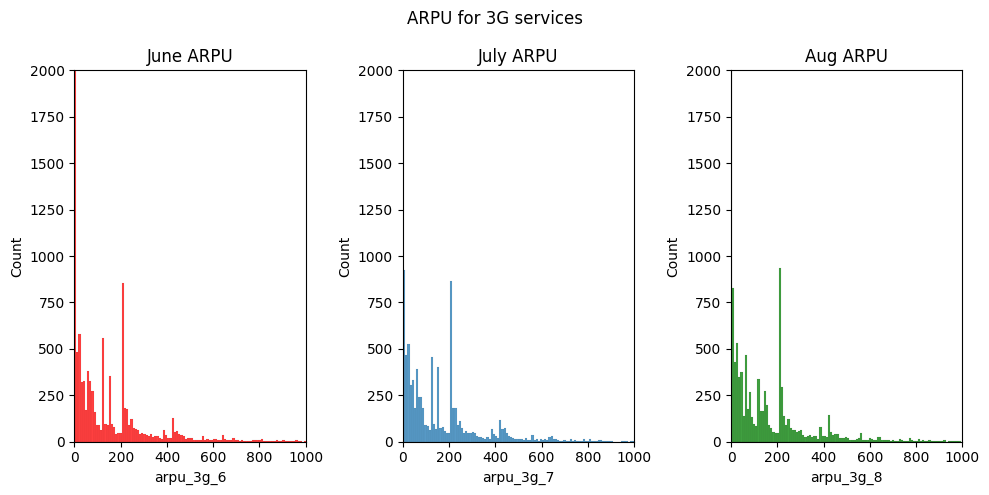

In [119]:
## Average Revenue per User (ARPU) 3G service
arpu = [col for col in list(eda.columns) if 'arpu' in col]
df = eda[arpu]

fig, ax = plt.subplots(1,3, figsize=(10,5))
plt.suptitle("ARPU for 3G services");

sns.histplot(df["arpu_3g_6"],ax=ax[0],color='r')
ax[0].set_title("June ARPU")
ax[0].set_xlim([0, 1000])
ax[0].set_ylim([0, 2000])

sns.histplot(df["arpu_3g_7"],ax=ax[1])
ax[1].set_title("July ARPU")
ax[1].set_xlim([0, 1000])
ax[1].set_ylim([0, 2000])

sns.histplot(df["arpu_3g_8"],ax=ax[2],color='g')
ax[2].set_title("Aug ARPU")
ax[2].set_xlim([0, 1000])
ax[2].set_ylim([0, 2000])

plt.show()

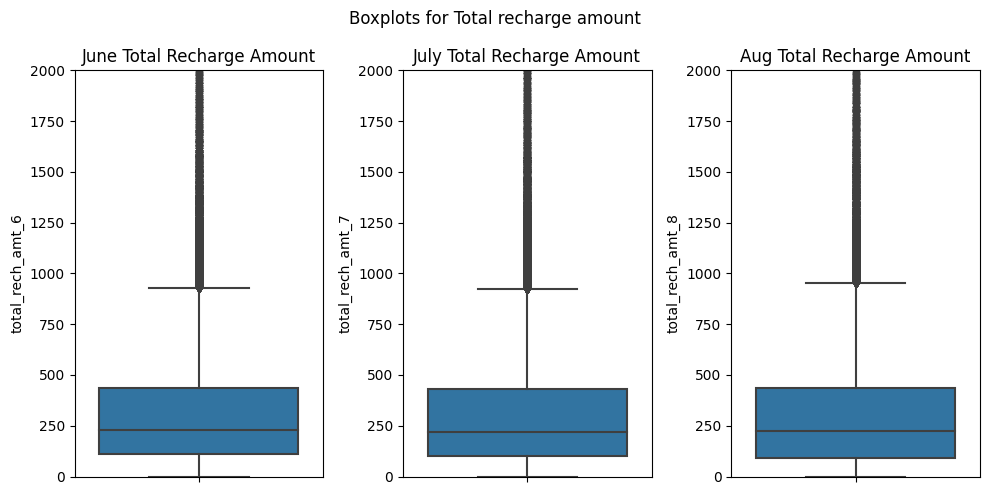

In [60]:
## Total Recharge Amount for all users
df = eda[["total_rech_amt_6","total_rech_amt_7","total_rech_amt_8"]]

fig, ax = plt.subplots(1,3, figsize=(10,5))
plt.suptitle("Boxplots for Total recharge amount");

sns.boxplot(df,y="total_rech_amt_6",ax=ax[0])
ax[0].set_title("June Total Recharge Amount")
ax[0].set_ylim([0, 2000])

sns.boxplot(df,y="total_rech_amt_7",ax=ax[1])
ax[1].set_title("July Total Recharge Amount")
ax[1].set_ylim([0, 2000])

sns.boxplot(df,y="total_rech_amt_8",ax=ax[2])
ax[2].set_title("Aug Total Recharge Amount")
ax[2].set_ylim([0, 2000])

plt.show()

Observation: <br>
The total recharge amount is roughly the same as well.

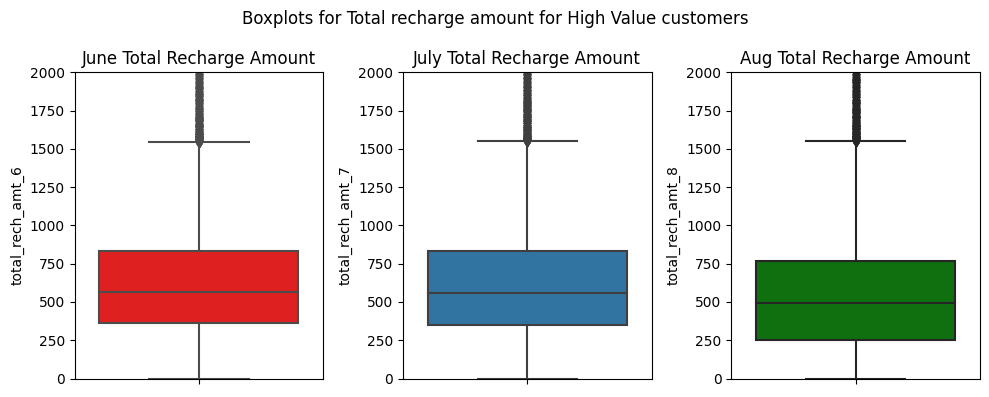

In [122]:
## Analysing data on High Value customers:
df = create_total_data_recharge_columns(eda)
df = filter_hvc(df)

fig, ax = plt.subplots(1,3, figsize=(10,4))
plt.suptitle("Boxplots for Total recharge amount for High Value customers");

sns.boxplot(df,y="total_rech_amt_6",ax=ax[0],color='r')
ax[0].set_title("June Total Recharge Amount")
ax[0].set_ylim([0, 2000])

sns.boxplot(df,y="total_rech_amt_7",ax=ax[1])
ax[1].set_title("July Total Recharge Amount")
ax[1].set_ylim([0, 2000])

sns.boxplot(df,y="total_rech_amt_8",ax=ax[2],color='g')
ax[2].set_title("Aug Total Recharge Amount")
ax[2].set_ylim([0, 2000])

plt.show()

Observations: <br>
1. The dataset has been refined for targeting high value customers.
2. For the entire set, the median value for customers is 250 INR, but for high value customers is 500 INR.
3. High value customers are generally recharging the same amount.

<b>Age on Network (AON)</b>

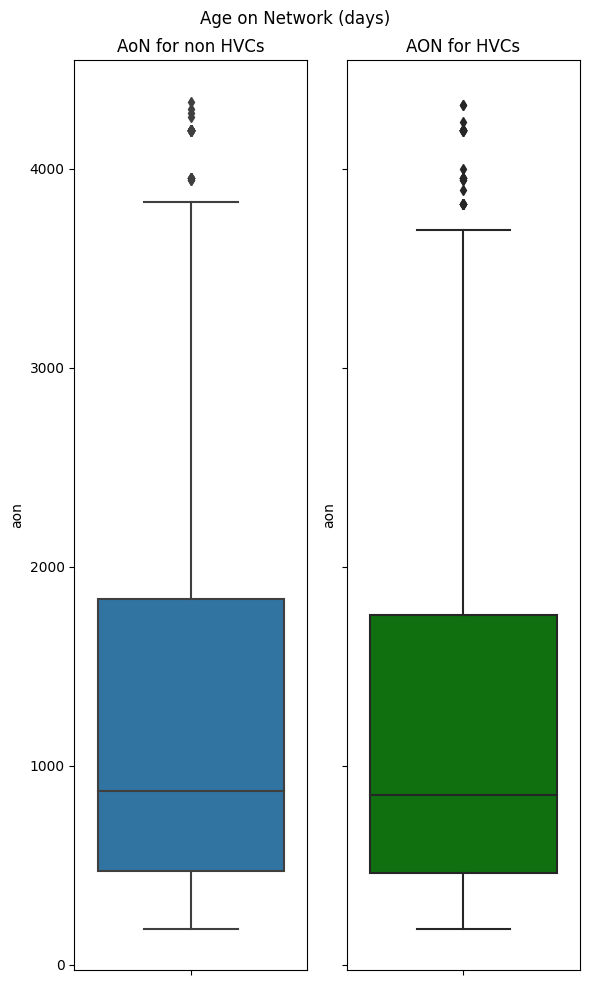

In [61]:
df = create_total_data_recharge_columns(eda)
hvc = filter_hvc(df) ## High Value customer data

index_hvc = hvc.index.tolist()
non_hvc = df[~df.index.isin(index_hvc)] ##Non High value customer

fig, ax = plt.subplots(1,2, figsize=(6,10), sharey=True)

sns.boxplot(non_hvc,y="aon",ax=ax[0])
ax[0].set_title("AoN for non HVCs")

sns.boxplot(hvc,y="aon",ax=ax[1],color='g')
ax[1].set_title("AON for HVCs")

plt.suptitle("Age on Network (days)")
plt.show();

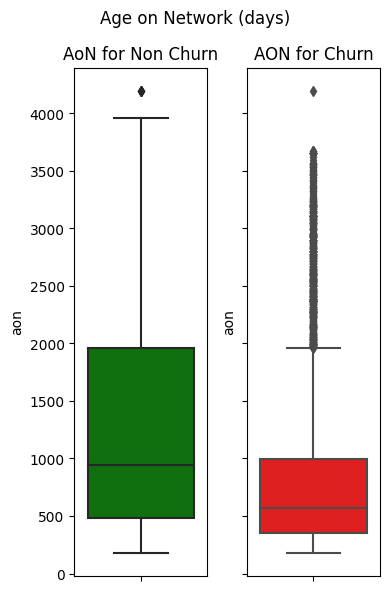

In [ ]:
df_1 = df[df["churn_probability"]==1]

df_0 = df[df["churn_probability"]==0]
df_0 = df_0.sample(len(df_1),random_state=seed) # Take same number of rows as in churn dataset.

fig, ax = plt.subplots(1,2, figsize=(4,6), sharey=True)

sns.boxplot(df_0,y="aon",ax=ax[0],color='green')
ax[0].set_title("AoN for Non Churn")

sns.boxplot(df_1,y="aon",ax=ax[1],color='red')
ax[1].set_title("AON for Churn")

plt.suptitle("Age on Network (days)")
plt.show();

<b> Observation: </b> <br>
1. The median Age on network for High value customers and Non High value customers are roughly the same.
2. The churn customers have a lower AON i.e. new customers are more likely to churn faster as they have not used their mobile numbers, thus can easily switch to a new service without consquences.

<b> Minutes of usage </b>

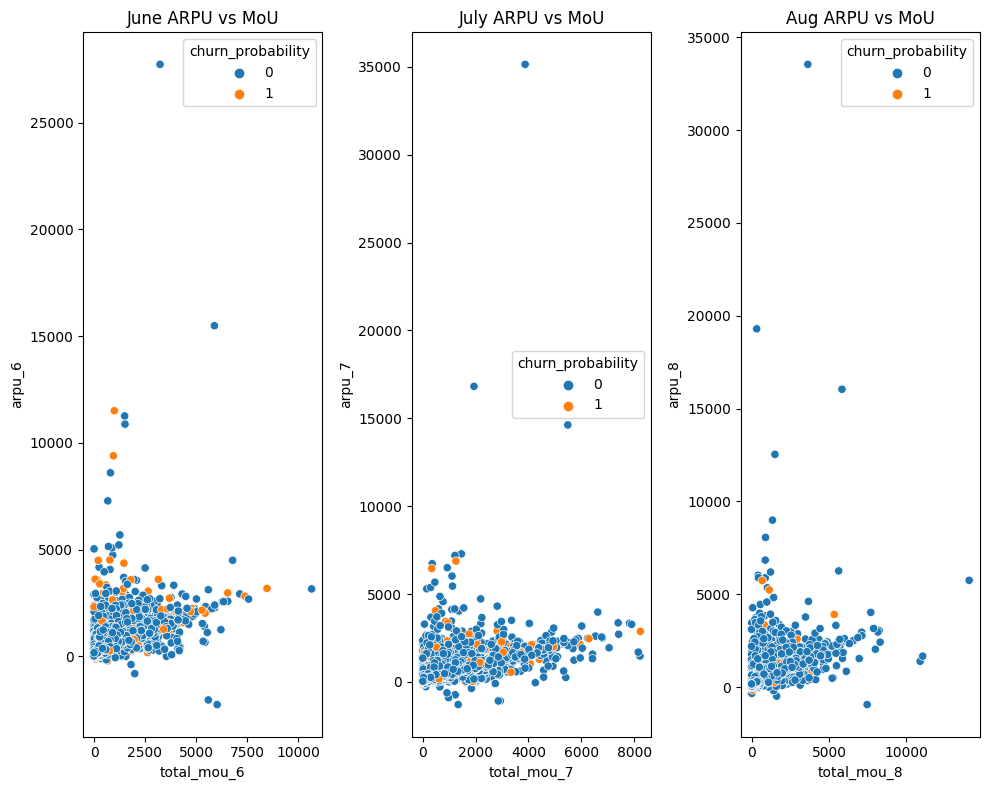

In [62]:
df = create_total_data_recharge_columns(eda)
hvc = filter_hvc(df) ## High Value customer data
index_hvc = hvc.index.tolist()

non_hvc = df[~df.index.isin(index_hvc)] ##Non High value customer

## Create the minutes of usage  columns:
df = create_mou(df)

fig, ax = plt.subplots(1,3, figsize=(10,8))

sns.scatterplot(y=df["arpu_6"],x=df["total_mou_6"],ax=ax[0],hue=df["churn_probability"])
ax[0].set_title("June ARPU vs MoU")

sns.scatterplot(y=df["arpu_7"],x=df["total_mou_7"],ax=ax[1],hue=df["churn_probability"])
ax[1].set_title("July ARPU vs MoU")

sns.scatterplot(y=df["arpu_8"],x=df["total_mou_8"],ax=ax[2],hue=df["churn_probability"])
ax[2].set_title("Aug ARPU vs MoU")
plt.show()


<b> Observation: </b> <br>
1. The good phase for the customers i.e months of June and July show that there is high usage of the network.
2. The churn phase (8th Month - Aug) sees lower usage.

<b>  Correlation Analysis </b>

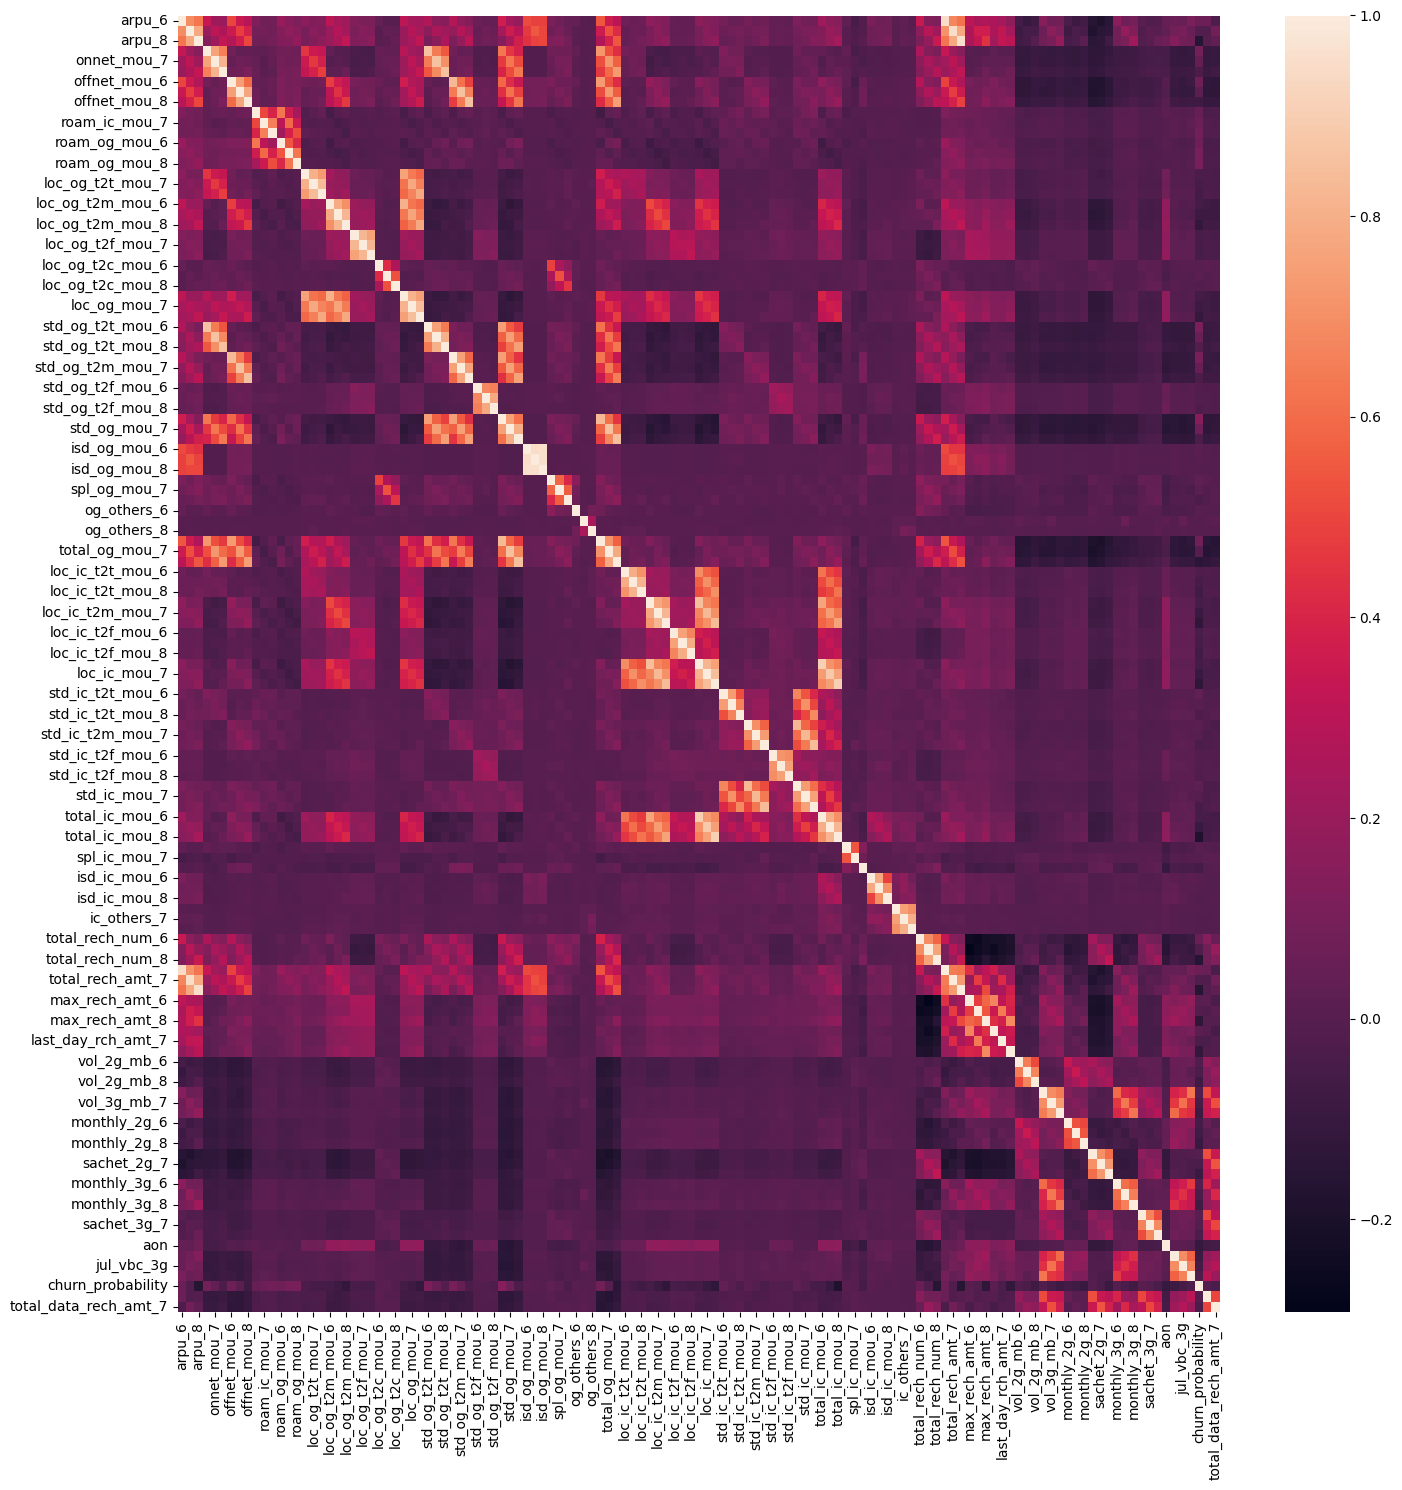

In [72]:
# Acquire the high value customers.
df = create_total_data_recharge_columns(eda)
df = filter_hvc(df)
df = missing_values(df)
df = redundant_columns(df)
corr = df.corr()
plt.figure(figsize=(15,15))
sns.heatmap(corr);

The heatmap is not exactly legible, inspite of removing a lot of columns. Thus, the below code will show the correlated features above a certain threshold defined by <i>corr_threshold </i>. 

In [64]:
corr = df.corr()
corr.loc[:, :] = np.tril(corr, -1)
corr = corr.stack()
high_corr_value = corr[(corr > corr_threshold) | (corr < -1*corr_threshold)]
high_corr_value.head(10) ## Only displaying top 10 for legibility.

arpu_8            arpu_7              0.781724
onnet_mou_7       onnet_mou_6         0.758087
onnet_mou_8       onnet_mou_7         0.809814
offnet_mou_7      offnet_mou_6        0.744686
offnet_mou_8      offnet_mou_7        0.768273
loc_og_t2t_mou_7  loc_og_t2t_mou_6    0.805506
loc_og_t2t_mou_8  loc_og_t2t_mou_6    0.736704
                  loc_og_t2t_mou_7    0.835972
loc_og_t2m_mou_7  loc_og_t2m_mou_6    0.787879
loc_og_t2m_mou_8  loc_og_t2m_mou_7    0.823089
dtype: float64

-----------------------

<h3><center> Data Preparation</center> </h3>

In [65]:
# Create a copy of the master table:
temp = master.copy()

### <font color='red'> High-value customers </font>: <br>
Those who have recharged with an amount more than or equal to X, where X is the 70th percentile of the average recharge amount in the first two months (the good phase).

Steps: <br>
1. Find out total amount spent by customers on data recharge.
2. Find averge for the good phase.
3. Calculate 70th percentile of recharge amount.

In [66]:
temp = create_total_data_recharge_columns(temp)
temp.shape

(69999, 170)

Filtering out the High Value customers from the dataset.

In [67]:
temp= filter_hvc(temp)
temp.shape

(20998, 170)

Removing the missing values

In [68]:
temp = missing_values(temp)
temp.shape

(20998, 144)

Dropping the correlated features

In [69]:
temp = drop_correlated_features(temp)
temp.shape

(20998, 105)

Creating new columns for the <i>Minutes of Usage</i> (MOU):

In [70]:
temp = create_mou(temp)
temp.shape

(20998, 102)

<b> Redundant Columns </b> <br>
Removing the date columns and single valued columns that are not necessary for our modelling purposes.

In [71]:
temp = redundant_columns(temp)
temp = vbc_cols(temp)
temp.shape

(20998, 84)

<b> Handling Outliers </b> <br>
The dataset has a lot of outliers, thus it is better to cap the important columns.

In [73]:
temp = cap_outlier(temp)
temp.shape

(20998, 84)

<b>Data Imputation</b> <br>
The rest of the numeric columns that might contain NaN values are replaced.

In [74]:
temp = impute_numeric(temp)
temp.shape

(20998, 84)

---

Split the features into independent and target variable:

In [75]:
y = temp["churn_probability"] 
X = temp.drop(["churn_probability"],axis=1)

Standardize the data

In [76]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

<b> Handling Class Imbalance </b><br>

<p>A problem with imbalanced classification is that there are too few examples of the minority class for a model to effectively learn the decision boundary.

One way to solve this problem is to oversample the examples in the minority class. This can be achieved by simply duplicating examples from the minority class in the training dataset prior to fitting a model. This can balance the class distribution but does not provide any additional information to the model.

An improvement on duplicating examples from the minority class is to synthesize new examples from the minority class. This is a type of data augmentation for tabular data and can be very effective. The most widely used approach to synthesizing new examples is called the Synthetic Minority Oversampling TEchnique, or SMOTE for short.</p>

In [77]:
y.value_counts(normalize=True)

0.0    0.917373
1.0    0.082627
Name: churn_probability, dtype: float64

In [78]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=seed)
X_res, y_res = sm.fit_resample(X_scaled,y)

In [79]:
y_res.value_counts()

0.0    19263
1.0    19263
Name: churn_probability, dtype: int64

<b> Dimensionality Reduction using PCA </b>

In [80]:
from sklearn.decomposition import PCA
pca = PCA(n_components=pca_comp)
X_pca = pca.fit_transform(X_res)

----

<h3> <center>Model Building</center></h3>

Approach 1: <b>XGBOOST</b>

In [ ]:
# Split the training dataset:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=test_set_size,random_state=seed)
cl = XGBClassifier()
cl.fit(X_train,y_train)
preds = cl.predict(X_test)

print(classification_report(y_test,preds))

<b>Hyperparameter Tuning for XGBoost </b><br>

<font color='red'>Note:</font> <br>
In the interest of training time, the below code has been commented. <br>
XGBoost is a very computationally expensive algorithm, thus using default parameters (as shown in the above code)

In [81]:
params = {'gamma': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4],
              'learning_rate': [0.01, 0.03, 0.06, 0.1, 0.15, 0.2, 0.4, 0.5, 0.6, 0.7],
              'max_depth': [5,6,7,8,10,20],
              'n_estimators': [50,80,100,150,250]
}

xgbc = XGBClassifier()    

#GridSearch instance of current iteration
clf = GridSearchCV(estimator=xgbc, param_grid=params, scoring='accuracy', return_train_score=True, verbose=1, cv=3)

# clf.fit(X_train, y_train) ### Beware: Will take excruciatingly long time!!

Approach 2: <b>Random Forest</b> <br>

In [84]:
# Split the training dataset:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=test_set_size,random_state=seed)

In [ ]:
# rf = RandomForestClassifier(random_state=seed, n_jobs=-1)
params = {
    'max_depth': [20, 30, 50,100],
    'min_samples_leaf': [5, 10, 20, 50],
    'min_samples_split': [2,3,5],    
    "criterion": ['gini', 'entropy']    
}

# random forest - the class weight is used to handle class imbalance - it adjusts the cost function
forest = RandomForestClassifier(n_jobs = -1,bootstrap=True,oob_score=True)

# create 5 folds
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = seed)

# create gridsearch object
model = GridSearchCV(estimator=forest, cv=folds, param_grid=params, n_jobs=-1, verbose=1, scoring="accuracy")

model.fit(X_train,y_train)
## Should roughly take 15mins (on 4 cores)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(n_jobs=-1, oob_score=True),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [20, 30, 50],
                         'min_samples_leaf': [5, 10, 20, 50],
                         'min_samples_split': [2, 3, 5]},
             scoring='accuracy', verbose=1)

In [ ]:
# Get the best estimator.
model.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=50, min_samples_leaf=5,
                       min_samples_split=3, n_jobs=-1, oob_score=True)

In [ ]:
# Get the best parameters.
model.best_params_

{'criterion': 'entropy',
 'max_depth': 50,
 'min_samples_leaf': 5,
 'min_samples_split': 3}

Matrix interpretation as per business context:

In [85]:
## Using our best parameters from GridSearch:
rf_best = RandomForestClassifier(n_estimators=100, max_depth=50, random_state=seed, min_samples_leaf=5, min_samples_split=3,criterion='entropy')
rf_best.fit(X_train,y_train)
y_test_pred  =  rf_best.predict(X_test)
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.95      0.96      3893
         1.0       0.95      0.97      0.96      3813

    accuracy                           0.96      7706
   macro avg       0.96      0.96      0.96      7706
weighted avg       0.96      0.96      0.96      7706



In [88]:
cm  = confusion_matrix(y_test,y_test_pred)
TP = cm[1,1] # true positive 
TN = cm[0,0] # true negatives
FP = cm[0,1] # false positives
FN = cm[1,0] # false negatives

print(cm)

[[3712  181]
 [ 117 3696]]


In [90]:
# Let's see the sensitivity(recall) of our logistic regression model
sens = TP / float(TP+FN)
print(f"Recall: {sens}")

Recall: 0.969315499606609


In predicting customer churn, a higher recall would be preferred to a higher precision, because it would be ideal to be able to predict which customers are at a higher risk of leaving. However tuning the threshold to achieve a higher recall comes at the cost of reducing the precision. Hence a balance needs to be achieved.

Approach 3: <br>
<b>Logistic Regression</b> <br>

<p>Experimentation via the Logistic Regression gave us very poor accuracy (~80%) on test set compared to Random Forest and XGBoost. <br>
Thus, the modelling section has been removed. Instead, we will use Logistic Regression to derive the important features for making strategies to deal with churn. <br> Random Forests and XGBoost, inspite of giving good results, doesn't provide interpretability like Logistic regression.

Derivation of Important features is shown below.
</p>

---------------------

<h3> <center>Testing on unseen data</center></h3>

We will be using Random Forest that has been trained in Approach 2. The primary reason for doing this is: <br>

Even though, XGboost and RF gave us nearly similar accuracy on the training data, hyper parameter tuning was much faster for RF than XGBoost, thus allowing us more degree of control on the modelling.


In [91]:
test = pd.read_csv("test.csv")

In [92]:
# Create a copy of the master table:
churn = test.copy()

## Repeat the steps to remove the necessary columns:
churn = create_total_data_recharge_columns(churn)
churn = missing_values(churn)
churn = drop_correlated_features(churn)
churn = create_mou(churn)
churn = redundant_columns(churn)
churn = vbc_cols(churn)
churn = cap_outlier(churn)
churn = impute_numeric(churn)

print(churn.shape)

(30000, 83)


In [93]:
model_input = churn.to_numpy()
model_input_pca = pca.fit_transform(model_input)

In [94]:
model_preds = rf_best.predict(model_input)
model_preds

array([0., 0., 0., ..., 0., 0., 0.])

In [95]:
result = {
    "id": test["id"],
    "churn_probability":model_preds
}
df_output = pd.DataFrame(result)
df_output["churn_probability"].value_counts()

0.0    27562
1.0     2438
Name: churn_probability, dtype: int64

<b> <font color='red'>**** Important*****</font></b>
- The final excel sheet ( <i>submission.csv</i> ) is likely to generate ~300 KB file<br>
- This file was not consumed by the Kaggle Competition submission section inspite of correct structure. Reasons unknown!<br>
- Thus we had to create a new .csv file and copy paste the results from <i>submission.csv</i>. <br>
- This results in ~250Kb file that was correctly consumed to generate the accuracy score.<br>

In [ ]:
## Create the output submission file:
# df_output.to_csv("submission.csv",index=False)

----

<h4> <center>Important Feature Extraction using Logistic Regression</center></h4>

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_set_size, random_state=seed)

In [97]:
import statsmodels.api as sm

# Initial logistic regression model
logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
logm1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:      churn_probability   No. Observations:                16798
Model:                            GLM   Df Residuals:                    16714
Model Family:                Binomial   Df Model:                           83
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2905.4
Date:                Wed, 18 Jan 2023   Deviance:                       5810.8
Time:                        23:08:42   Pearson chi2:                 2.34e+05
No. Iterations:                    12   Pseudo R-squ. (CS):             0.2051
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -1.4630      0.118    -12.373      0.000      -1.695      -1.231
arpu_6                    0.0002      0.000      1.298      0.194      -0.000       0.001
arpu_7                    0.0001      0.000      0.527      0.598      -0.000       0.001
arpu_8                   -0.0003      0.000     -1.246      0.213      -0.001       0.000
roam_ic_mou_6             0.0010      0.001      1.725      0.085      -0.000       0.002
roam_ic_mou_7         -2.911e-05      0.001     -0.055      0.956      -0.001       0.001
roam_ic_mou_8         -5.764e-05      0.000     -0.119      0.905      -0.001       0.001
roam_og_mou_6             0.0098      0.005      1.921      0.055      -0.000       0.020
roam_og_mou_7             0.0031      0.004      0.736      0.461      -0.005       0.011
roam_og_mou_8             0.0006      0.001      0.646      0.518      -0.001       0.002
loc_og_t2c_mou_6         -0.0110      0.007     -1.550      0.121      -0.025       0.003
loc_og_t2c_mou_7          0.0012      0.005      0.246      0.806      -0.008       0.011
loc_og_t2c_mou_8          0.0055      0.007      0.774      0.439      -0.008       0.019
loc_og_mou_6              0.0096      0.005      1.896      0.058      -0.000       0.020
loc_og_mou_7              0.0010      0.004      0.240      0.810      -0.007       0.009
loc_og_mou_8              0.0007      0.001      0.816      0.414      -0.001       0.003
std_og_t2f_mou_6         -0.0033      0.005     -0.604      0.546      -0.014       0.007
std_og_t2f_mou_7          0.0052      0.006      0.942      0.346      -0.006       0.016
std_og_t2f_mou_8         -0.0081      0.010     -0.854      0.393      -0.027       0.011
std_og_mou_6              0.0098      0.005      1.924      0.054      -0.000       0.020
std_og_mou_7              0.0019      0.004      0.448      0.654      -0.006       0.010
std_og_mou_8             -0.0005      0.001     -0.507      0.612      -0.002       0.001
isd_og_mou_6              0.0104      0.005      2.026      0.043       0.000       0.020
isd_og_mou_7              0.0036      0.004      0.806      0.420      -0.005       0.012
isd_og_mou_8             -0.0051      0.004     -1.229      0.219      -0.013       0.003
spl_og_mou_6              0.0120      0.005      2.243      0.025       0.002       0.023
spl_og_mou_7              0.0026      0.004      0.594      0.553      -0.006       0.011
spl_og_mou_8             -0.0050      0.004     -1.255      0.209      -0.013       0.003
og_others_6              -0.0377      0.019     -1.997      0.046      -0.075      -0.001
og_others_7               0.1646      0.164      1.002      0.316      -0.157       0.486
og_others_8              -0.9059      0.870     -1.042      0.298      -2.610       0.799
loc_ic_mou_6           

In [98]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

# Create LR object
logreg = LogisticRegression(solver='liblinear')

# Run RFE for 25 features
rfe = RFE(logreg, n_features_to_select=30)
rfe = rfe.fit(X_train, y_train)

rfe_col = X.columns[rfe.support_]
rfe_col

Index(['roam_og_mou_7', 'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7',
       'std_og_t2f_mou_8', 'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8',
       'spl_og_mou_6', 'spl_og_mou_8', 'loc_ic_mou_7', 'loc_ic_mou_8',
       'std_ic_t2t_mou_7', 'std_ic_t2t_mou_8', 'std_ic_t2f_mou_8',
       'std_ic_mou_8', 'ic_others_7', 'total_rech_num_6', 'total_rech_num_7',
       'total_rech_num_8', 'last_day_rch_amt_8', 'monthly_2g_6',
       'monthly_2g_7', 'monthly_2g_8', 'sachet_2g_6', 'sachet_2g_7',
       'sachet_2g_8', 'monthly_3g_6', 'monthly_3g_7', 'monthly_3g_8',
       'sachet_3g_8'],
      dtype='object')

In [99]:
# Build model with RFE selected features
X_train_sm = sm.add_constant(X_train[rfe_col])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:      churn_probability   No. Observations:                16798
Model:                            GLM   Df Residuals:                    16767
Model Family:                Binomial   Df Model:                           30
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3281.0
Date:                Wed, 18 Jan 2023   Deviance:                       6562.1
Time:                        23:11:09   Pearson chi2:                 8.87e+05
No. Iterations:                     8   Pseudo R-squ. (CS):             0.1687
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.6480      0.075     -8.694      0.000      -0.794      -0.502
roam_og_mou_7          0.0022      0.000      8.703      0.000       0.002       0.003
loc_og_t2c_mou_6      -0.0145      0.007     -2.117      0.034      -0.028      -0.001
loc_og_t2c_mou_7       0.0058      0.004      1.554      0.120      -0.002       0.013
std_og_t2f_mou_8      -0.0085      0.008     -1.032      0.302      -0.025       0.008
isd_og_mou_6           0.0032      0.002      2.026      0.043       0.000       0.006
isd_og_mou_7           0.0050      0.003      1.455      0.146      -0.002       0.012
isd_og_mou_8          -0.0078      0.004     -2.172      0.030      -0.015      -0.001
spl_og_mou_6           0.0028      0.002      1.170      0.242      -0.002       0.008
spl_og_mou_8          -0.0090      0.004     -2.570      0.010      -0.016      -0.002
loc_ic_mou_7           0.0023      0.000      9.230      0.000       0.002       0.003
loc_ic_mou_8          -0.0102      0.001    -18.174      0.000      -0.011      -0.009
std_ic_t2t_mou_7       0.0027      0.001      3.636      0.000       0.001       0.004
std_ic_t2t_mou_8      -0.0069      0.003     -2.694      0.007      -0.012      -0.002
std_ic_t2f_mou_8      -0.0064      0.008     -0.815      0.415      -0.022       0.009
std_ic_mou_8          -0.0017      0.001     -2.060      0.039      -0.003    -8.4e-05
ic_others_7           -0.0011      0.004     -0.265      0.791      -0.009       0.007
total_rech_num_6       0.0214      0.004      4.995      0.000       0.013       0.030
total_rech_num_7       0.0193      0.006      3.349      0.001       0.008       0.031
total_rech_num_8      -0.0992      0.008    -12.528      0.000      -0.115      -0.084
last_day_rch_amt_8    -0.0051      0.001     -9.794      0.000      -0.006      -0.004
monthly_2g_6          -0.0539      0.100     -0.537      0.591      -0.251       0.143
monthly_2g_7          -0.3384      0.115     -2.949      0.003      -0.563      -0.114
monthly_2g_8          -1.3531      0.194     -6.975      0.000      -1.733      -0.973
sachet_2g_6            0.0151      0.018      0.842      0.400      -0.020       0.050
sachet_2g_7           -0.0032      0.021     -0.153      0.879      -0.045       0.038
sachet_2g_8           -0.2799      0.037     -7.563      0.000      -0.352      -0.207
monthly_3g_6           0.1856      0.071      2.605      0.009       0.046       0.325
monthly_3g_7          -0.1256      0.085     -1.482      0.138      -0.292       0.041
monthly_3g_8          -0.7314      0.124     -5.907      0.000      -0.974      -0.489
sachet_3g_8           -0.2219      0.082     -2.712      0.007      -0.382      -0.062
======================================================================================
"""

In [100]:
# Predict on train data
y_train_pred = res.predict(X_train_sm).values.reshape(-1)
y_train_pred_final = pd.DataFrame({'Churn':y_train.values, 'Churn_Prob':y_train_pred})
y_train_pred_final['predicted'] = y_train_pred_final.Churn_Prob.map(lambda x: 1 if x > 0.5 else 0)
y_train_pred_final.head()

,Churn,Churn_Prob,predicted
0,0.0,0.008032,0
1,0.0,0.016687,0
2,1.0,0.831558,1
3,0.0,0.017399,0
4,0.0,0.001847,0


In [101]:
from sklearn.metrics import accuracy_score, confusion_matrix
# Confusion matrix 
confusion = confusion_matrix(y_train_pred_final.Churn, y_train_pred_final.predicted )
print(confusion)

# The overall accuracy.
print(f'Accuracy : {accuracy_score(y_train_pred_final.Churn, y_train_pred_final.predicted)}')

[[15241   151]
 [ 1111   295]]
Accuracy : 0.9248720085724491


In [102]:
# Check for the VIF values of the feature variables. 
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train[rfe_col].columns
vif['VIF'] = [variance_inflation_factor(X_train[rfe_col].values, i) for i in range(X_train[rfe_col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
17,total_rech_num_7,9.45
5,isd_og_mou_7,7.20
6,isd_og_mou_8,6.68
18,total_rech_num_8,6.63
16,total_rech_num_6,5.58
10,loc_ic_mou_8,5.27
9,loc_ic_mou_7,5.25
4,isd_og_mou_6,4.35
24,sachet_2g_7,3.87
25,sachet_2g_8,3.08


In [103]:
rfe_col = rfe_col.drop('total_rech_num_7', 1) # DRop the top feature and recheck VIF values.

# Build new model
X_train_sm = sm.add_constant(X_train[rfe_col])
logm3 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm3.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:      churn_probability   No. Observations:                16798
Model:                            GLM   Df Residuals:                    16768
Model Family:                Binomial   Df Model:                           29
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3286.6
Date:                Wed, 18 Jan 2023   Deviance:                       6573.3
Time:                        23:11:12   Pearson chi2:                 9.65e+05
No. Iterations:                     8   Pseudo R-squ. (CS):             0.1682
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.6046      0.073     -8.267      0.000      -0.748      -0.461
roam_og_mou_7          0.0022      0.000      8.796      0.000       0.002       0.003
loc_og_t2c_mou_6      -0.0149      0.007     -2.197      0.028      -0.028      -0.002
loc_og_t2c_mou_7       0.0071      0.004      2.003      0.045       0.000       0.014
std_og_t2f_mou_8      -0.0089      0.008     -1.073      0.283      -0.025       0.007
isd_og_mou_6           0.0029      0.002      1.866      0.062      -0.000       0.006
isd_og_mou_7           0.0054      0.003      1.556      0.120      -0.001       0.012
isd_og_mou_8          -0.0080      0.004     -2.216      0.027      -0.015      -0.001
spl_og_mou_6           0.0026      0.002      1.101      0.271      -0.002       0.007
spl_og_mou_8          -0.0091      0.003     -2.610      0.009      -0.016      -0.002
loc_ic_mou_7           0.0024      0.000      9.799      0.000       0.002       0.003
loc_ic_mou_8          -0.0104      0.001    -18.513      0.000      -0.012      -0.009
std_ic_t2t_mou_7       0.0029      0.001      3.914      0.000       0.001       0.004
std_ic_t2t_mou_8      -0.0070      0.003     -2.721      0.007      -0.012      -0.002
std_ic_t2f_mou_8      -0.0060      0.008     -0.772      0.440      -0.021       0.009
std_ic_mou_8          -0.0017      0.001     -2.063      0.039      -0.003   -8.61e-05
ic_others_7           -0.0009      0.004     -0.214      0.830      -0.009       0.007
total_rech_num_6       0.0283      0.004      7.551      0.000       0.021       0.036
total_rech_num_8      -0.0875      0.007    -12.446      0.000      -0.101      -0.074
last_day_rch_amt_8    -0.0052      0.001     -9.931      0.000      -0.006      -0.004
monthly_2g_6          -0.0774      0.100     -0.771      0.440      -0.274       0.119
monthly_2g_7          -0.3218      0.115     -2.810      0.005      -0.546      -0.097
monthly_2g_8          -1.3731      0.194     -7.075      0.000      -1.753      -0.993
sachet_2g_6            0.0027      0.018      0.154      0.877      -0.032       0.037
sachet_2g_7            0.0191      0.020      0.955      0.340      -0.020       0.058
sachet_2g_8           -0.2945      0.037     -8.017      0.000      -0.366      -0.222
monthly_3g_6           0.1671      0.071      2.345      0.019       0.027       0.307
monthly_3g_7          -0.1019      0.084     -1.206      0.228      -0.267       0.064
monthly_3g_8          -0.7478      0.124     -6.038      0.000      -0.991      -0.505
sachet_3g_8           -0.2209      0.082     -2.705      0.007      -0.381      -0.061
======================================================================================
"""

In [104]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train[rfe_col].columns
vif['VIF'] = [variance_inflation_factor(X_train[rfe_col].values, i) for i in range(X_train[rfe_col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
5,isd_og_mou_7,7.17
6,isd_og_mou_8,6.66
10,loc_ic_mou_8,5.22
9,loc_ic_mou_7,5.16
4,isd_og_mou_6,4.34
17,total_rech_num_8,4.05
16,total_rech_num_6,3.87
23,sachet_2g_7,3.33
24,sachet_2g_8,2.95
22,sachet_2g_6,2.63


In [105]:
rfe_col = rfe_col.drop('isd_og_mou_7', 1) # DRop the top feature and recheck VIF values.

# Build new model
X_train_sm = sm.add_constant(X_train[rfe_col])
logm3 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm3.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:      churn_probability   No. Observations:                16798
Model:                            GLM   Df Residuals:                    16769
Model Family:                Binomial   Df Model:                           28
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3288.2
Date:                Wed, 18 Jan 2023   Deviance:                       6576.4
Time:                        23:11:13   Pearson chi2:                 9.82e+05
No. Iterations:                     8   Pseudo R-squ. (CS):             0.1680
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.5990      0.073     -8.200      0.000      -0.742      -0.456
roam_og_mou_7          0.0022      0.000      8.779      0.000       0.002       0.003
loc_og_t2c_mou_6      -0.0150      0.007     -2.210      0.027      -0.028      -0.002
loc_og_t2c_mou_7       0.0073      0.004      2.035      0.042       0.000       0.014
std_og_t2f_mou_8      -0.0091      0.008     -1.094      0.274      -0.025       0.007
isd_og_mou_6           0.0038      0.002      2.509      0.012       0.001       0.007
isd_og_mou_8          -0.0030      0.002     -2.011      0.044      -0.006   -7.75e-05
spl_og_mou_6           0.0026      0.002      1.096      0.273      -0.002       0.007
spl_og_mou_8          -0.0092      0.003     -2.626      0.009      -0.016      -0.002
loc_ic_mou_7           0.0024      0.000      9.841      0.000       0.002       0.003
loc_ic_mou_8          -0.0104      0.001    -18.512      0.000      -0.012      -0.009
std_ic_t2t_mou_7       0.0029      0.001      3.960      0.000       0.001       0.004
std_ic_t2t_mou_8      -0.0070      0.003     -2.718      0.007      -0.012      -0.002
std_ic_t2f_mou_8      -0.0059      0.008     -0.765      0.444      -0.021       0.009
std_ic_mou_8          -0.0017      0.001     -2.073      0.038      -0.003   -9.44e-05
ic_others_7           -0.0008      0.004     -0.200      0.841      -0.009       0.007
total_rech_num_6       0.0282      0.004      7.510      0.000       0.021       0.036
total_rech_num_8      -0.0877      0.007    -12.473      0.000      -0.101      -0.074
last_day_rch_amt_8    -0.0052      0.001     -9.937      0.000      -0.006      -0.004
monthly_2g_6          -0.0798      0.100     -0.796      0.426      -0.276       0.117
monthly_2g_7          -0.3218      0.114     -2.812      0.005      -0.546      -0.098
monthly_2g_8          -1.3738      0.194     -7.079      0.000      -1.754      -0.993
sachet_2g_6            0.0025      0.018      0.139      0.889      -0.032       0.037
sachet_2g_7            0.0190      0.020      0.947      0.344      -0.020       0.058
sachet_2g_8           -0.2947      0.037     -8.018      0.000      -0.367      -0.223
monthly_3g_6           0.1694      0.071      2.380      0.017       0.030       0.309
monthly_3g_7          -0.1030      0.084     -1.220      0.223      -0.269       0.063
monthly_3g_8          -0.7509      0.124     -6.063      0.000      -0.994      -0.508
sachet_3g_8           -0.2215      0.082     -2.709      0.007      -0.382      -0.061
======================================================================================
"""

In [106]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train[rfe_col].columns
vif['VIF'] = [variance_inflation_factor(X_train[rfe_col].values, i) for i in range(X_train[rfe_col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
9,loc_ic_mou_8,5.22
8,loc_ic_mou_7,5.16
16,total_rech_num_8,4.04
15,total_rech_num_6,3.87
4,isd_og_mou_6,3.65
5,isd_og_mou_8,3.64
22,sachet_2g_7,3.33
23,sachet_2g_8,2.95
21,sachet_2g_6,2.63
11,std_ic_t2t_mou_8,2.62


In [107]:
rfe_col = rfe_col.drop('loc_ic_mou_8', 1) # DRop the top feature and recheck VIF values.

# Build new model
X_train_sm = sm.add_constant(X_train[rfe_col])
logm3 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm3.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:      churn_probability   No. Observations:                16798
Model:                            GLM   Df Residuals:                    16770
Model Family:                Binomial   Df Model:                           27
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3568.7
Date:                Wed, 18 Jan 2023   Deviance:                       7137.4
Time:                        23:11:15   Pearson chi2:                 5.51e+06
No. Iterations:                     8   Pseudo R-squ. (CS):             0.1398
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.6970      0.072     -9.615      0.000      -0.839      -0.555
roam_og_mou_7          0.0025      0.000     10.148      0.000       0.002       0.003
loc_og_t2c_mou_6      -0.0162      0.007     -2.334      0.020      -0.030      -0.003
loc_og_t2c_mou_7       0.0076      0.004      1.839      0.066      -0.001       0.016
std_og_t2f_mou_8      -0.0172      0.010     -1.721      0.085      -0.037       0.002
isd_og_mou_6           0.0041      0.002      2.697      0.007       0.001       0.007
isd_og_mou_8          -0.0032      0.002     -2.116      0.034      -0.006      -0.000
spl_og_mou_6           0.0037      0.002      1.596      0.111      -0.001       0.008
spl_og_mou_8          -0.0138      0.004     -3.577      0.000      -0.021      -0.006
loc_ic_mou_7          -0.0013      0.000     -7.180      0.000      -0.002      -0.001
std_ic_t2t_mou_7       0.0041      0.001      5.715      0.000       0.003       0.006
std_ic_t2t_mou_8      -0.0101      0.003     -3.328      0.001      -0.016      -0.004
std_ic_t2f_mou_8      -0.0299      0.011     -2.672      0.008      -0.052      -0.008
std_ic_mou_8          -0.0037      0.001     -3.376      0.001      -0.006      -0.002
ic_others_7           -0.0002      0.003     -0.074      0.941      -0.005       0.005
total_rech_num_6       0.0417      0.004     11.065      0.000       0.034       0.049
total_rech_num_8      -0.1290      0.007    -17.707      0.000      -0.143      -0.115
last_day_rch_amt_8    -0.0077      0.001    -14.328      0.000      -0.009      -0.007
monthly_2g_6          -0.0743      0.098     -0.760      0.447      -0.266       0.117
monthly_2g_7          -0.3611      0.112     -3.229      0.001      -0.580      -0.142
monthly_2g_8          -1.4939      0.190     -7.845      0.000      -1.867      -1.121
sachet_2g_6           -0.0087      0.017     -0.500      0.617      -0.043       0.025
sachet_2g_7            0.0364      0.019      1.868      0.062      -0.002       0.075
sachet_2g_8           -0.3138      0.037     -8.379      0.000      -0.387      -0.240
monthly_3g_6           0.1985      0.070      2.838      0.005       0.061       0.336
monthly_3g_7          -0.1236      0.084     -1.478      0.139      -0.288       0.040
monthly_3g_8          -0.7986      0.124     -6.459      0.000      -1.041      -0.556
sachet_3g_8           -0.2281      0.084     -2.710      0.007      -0.393      -0.063
======================================================================================
"""

In [108]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train[rfe_col].columns
vif['VIF'] = [variance_inflation_factor(X_train[rfe_col].values, i) for i in range(X_train[rfe_col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
15,total_rech_num_8,3.97
14,total_rech_num_6,3.84
4,isd_og_mou_6,3.65
5,isd_og_mou_8,3.64
21,sachet_2g_7,3.33
22,sachet_2g_8,2.95
20,sachet_2g_6,2.63
10,std_ic_t2t_mou_8,2.62
12,std_ic_mou_8,2.34
24,monthly_3g_7,2.28


In [109]:
X_test = X_test[rfe_col]
X_test_sm = sm.add_constant(X_test)

# Predict on test data

y_test_pred = res.predict(X_test_sm)
y_test_pred_final = pd.DataFrame({'Churn':y_test.values, 'Churn_Prob':y_test_pred})
y_test_pred_final['predicted'] = y_test_pred_final.Churn_Prob.map(lambda x: 1 if x > 0.5 else 0)
y_test_pred_final.head()

,Churn,Churn_Prob,predicted
7752,0.0,0.147390,0
49756,0.0,0.008028,0
46982,0.0,0.000214,0
67518,0.0,0.003445,0
7725,0.0,0.051110,0


In [110]:
# Confusion matrix 
confusion = confusion_matrix(y_train_pred_final.Churn, y_train_pred_final.predicted )
print(confusion)

# The overall accuracy.
print(f'Accuracy : {accuracy_score(y_train_pred_final.Churn, y_train_pred_final.predicted)}')

[[15241   151]
 [ 1111   295]]
Accuracy : 0.9248720085724491


Inspite of drop in features, the accuracy is fairly well maintained. <br> Thus, we can go ahead with understanding the top 10 features that can be monitored to predict churn.

In [51]:
top_10 = abs(res.params).sort_values(ascending=False)[0:11]
top_10.pop('const')
print(top_10)

monthly_2g_8        1.493918
monthly_3g_8        0.798612
monthly_2g_7        0.361135
sachet_2g_8         0.313770
sachet_3g_8         0.228147
monthly_3g_6        0.198453
total_rech_num_8    0.128991
monthly_3g_7        0.123632
monthly_2g_6        0.074338
total_rech_num_6    0.041683
dtype: float64


<h3><center>Interpretation of features</center></h3>
From the above list, it can be seen that the metrics of the <b>'action'</b> phase are quite important. Monitoring the important metrics in the 8th month can help to prevent customer churn. The features to be kept in mind are: <br>

1. **Monthly Recharge of 2G and 3G**: Is the user recharging for large amount of data or not?
2. **Sachet schemes for 2G and 3G** : Is the user recharging for smaller amount. This could mean reduction in spend and thus churn.
3. **Total amount of recharge** : What is the amount of recharge done for the action phase? 
4. **Data Recharge**: Amount of data recharge in the good phase of customer

Although, the below metrics do not show up in the list, domain expertise would show that the following metrics are quite important as well: <br>

1. **ARPU** : Tracking Average revenue per user for good and churn phase is important.
2. **MOU** : Minutes of usage for good and churn phase - lower MoU could mean an indication to churn.
3. **AoN**  : As seen during EDA, newer customers are more likely to churn. This is likely because they have not extensively used their number and thus can easily switch to a different network.

----